##### Course Name: CSC 785: Info Storage & Retrieval
##### Project Name: PageRank Personalized: Optimizing Web Search with Logistic Regression
##### Contributor Names: Abdullah Al Rakin & Mohammad Navid Nayyem

## Import all necessary libraries

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Creating a Browser History Dataset from SQLite Database

In [ ]:
def date_from_webkit(webkit_timestamp):
    epoch_start = datetime(1601, 1, 1)
    delta = timedelta(microseconds=int(webkit_timestamp))
    return epoch_start + delta

# Database path of the browser history on our systems, Navid also gave his path (the commented out one)
db_path = '/Users/abdullahalrakin/Library/Application Support/BraveSoftware/Brave-Browser/Default/History'
#db_path = 'C:\\Users\\Mohammad Navid\\AppData\\Local\\Google\\Chrome\\User Data\\Default\\History'

end_date = datetime.now()
start_date = end_date - timedelta(days=90)

# Database connection
with sqlite3.connect(db_path) as con:
    cur = con.cursor() 
    cur.execute("""
        SELECT visits.visit_time, urls.last_visit_time, 
               (urls.last_visit_time - visits.visit_time), 
               urls.url, urls.title, urls.visit_count 
        FROM urls JOIN visits ON urls.id = visits.id;
    """)
    results = cur.fetchall()

print(f"Total: {len(results)} results...")

# Convert the results to a DataFrame
df = pd.DataFrame(results, columns=['First Visit Time', 'Last Visit Time', 'Duration', 'URL', 'Title', 'Total Visit Count'])

# Convert time columns to datetime format
df['First Visit Time'] = df['First Visit Time'].apply(lambda x: date_from_webkit(x).strftime('%Y-%m-%d %H:%M:%S'))
df['Last Visit Time'] = df['Last Visit Time'].apply(lambda x: date_from_webkit(x).strftime('%Y-%m-%d %H:%M:%S'))

# Calculate duration in seconds and then convert it to HH:MM:SS format
df['Duration'] = pd.to_datetime(df['Duration'], format = "%Y-%m-%d %H:%M:%S").dt.strftime('%H:%M:%S')

# Print and save the DataFrame
print(df)
df.to_csv('/Users/abdullahalrakin/Desktop/Browser_History.csv', index=False, header=True)
#df.to_csv('C:\\Users\\Mohammad Navid\\Desktop\\Browser_History.csv', index=False, header=True) #Navid's csv path

## Load the dataset

In [3]:
df = pd.read_csv('/Users/abdullahalrakin/Desktop/Browser_History.csv')

## Preview the dataset

In [4]:
df

,First Visit Time,Last Visit Time,Duration,URL,Title,Total Visit Count
0,9/4/2023 6:33,11/21/2023 8:41,1:52:26,https://d2l.sdbor.edu/d2l/home,Homepage - South Dakota Board of Regents,455
1,9/4/2023 6:33,11/3/2023 1:41,1:26:06,https://my.usd.edu/uPortal/f/welcome/normal/re...,Welcome | myUSD Portal,24
2,9/4/2023 6:33,11/19/2023 18:18,1:50:08,https://quikpayasp.com/sdbor/quikpay/spa/viewa...,QuikPAY(R) View & Pay Accounts,22
3,9/4/2023 6:33,10/9/2023 18:00,0:51:05,https://students.care26.com/login,Care26 Student,7
4,9/4/2023 6:33,11/3/2023 1:41,1:26:06,https://my.usd.edu/uPortal/Login?refUrl=%2FuPo...,Welcome | myUSD Portal,24
...,...,...,...,...,...,...
14966,9/27/2023 3:29,12/3/2023 21:42,1:37:34,https://search.brave.com/search?q=how+to+open+...,how to open terminal in mac - Brave Search,2
14967,9/27/2023 3:29,12/3/2023 21:44,1:37:34,file:///Users/abdullahalrakin/Library/Jupyter/...,Opening Jupyter Notebook,1
14968,9/27/2023 3:29,12/3/2023 21:44,1:37:34,http://localhost:8888/tree?token=3780a49de3376...,Home Page - Select or create a notebook,1
14969,9/27/2023 3:29,12/3/2023 21:49,1:37:34,file:///Users/abdullahalrakin/Library/Jupyter/...,Opening Jupyter Notebook,1


## Drop unnecessary columns

In [5]:
df = df.drop(columns=['First Visit Time', 'Last Visit Time'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14971 entries, 0 to 14970
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Duration           14971 non-null  object
 1   URL                14971 non-null  object
 2   Title              14674 non-null  object
 3   Total Visit Count  14971 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 468.0+ KB
None


## Feature engineering for time-related columns

In [6]:
df['Duration'] = pd.to_timedelta(df['Duration']).dt.total_seconds()

## Extract relevant information from URL and Title

In [7]:
df['Domain'] = df['URL'].apply(lambda x: x.split('/')[2] if isinstance(x, str) and len(x.split('/')) > 2 else None)
df['Keyword'] = df['Title'].apply(lambda x: x.split(' ')[0] if isinstance(x, str) else None)

## Generating a Binary Target Variable named 'Interested'

In [8]:
df['Interested'] = (df['Total Visit Count']).astype(int)

## Visualization 01: Top 20 visited domains

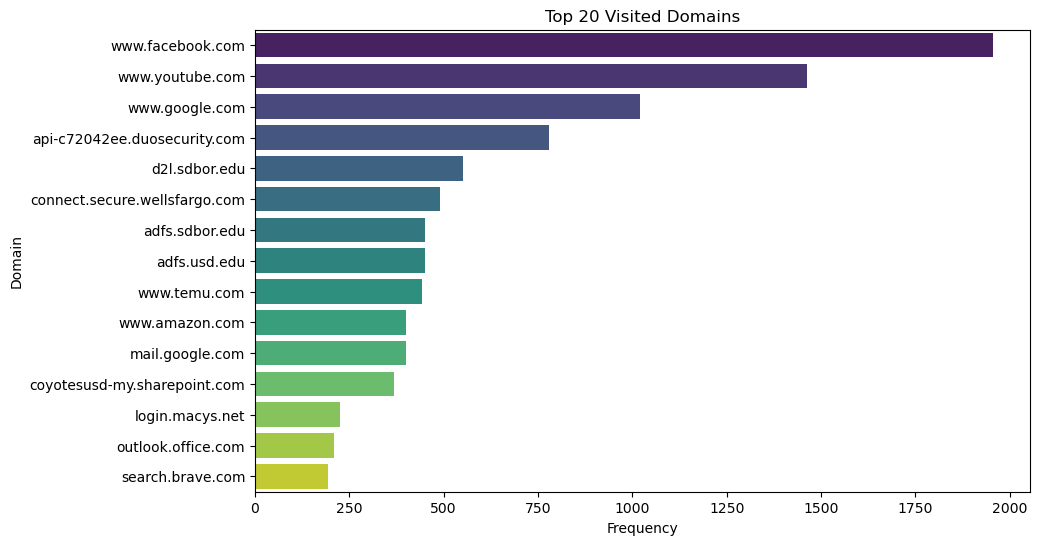

In [9]:
top_domains = df['Domain'].value_counts().nlargest(15) 
plt.figure(figsize=(10, 6))
sns.barplot(x=top_domains.values, y=top_domains.index, palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Domain')
plt.title('Top 20 Visited Domains')
plt.show()

## Visualization 02: Mean duration for top 5 visited URLs

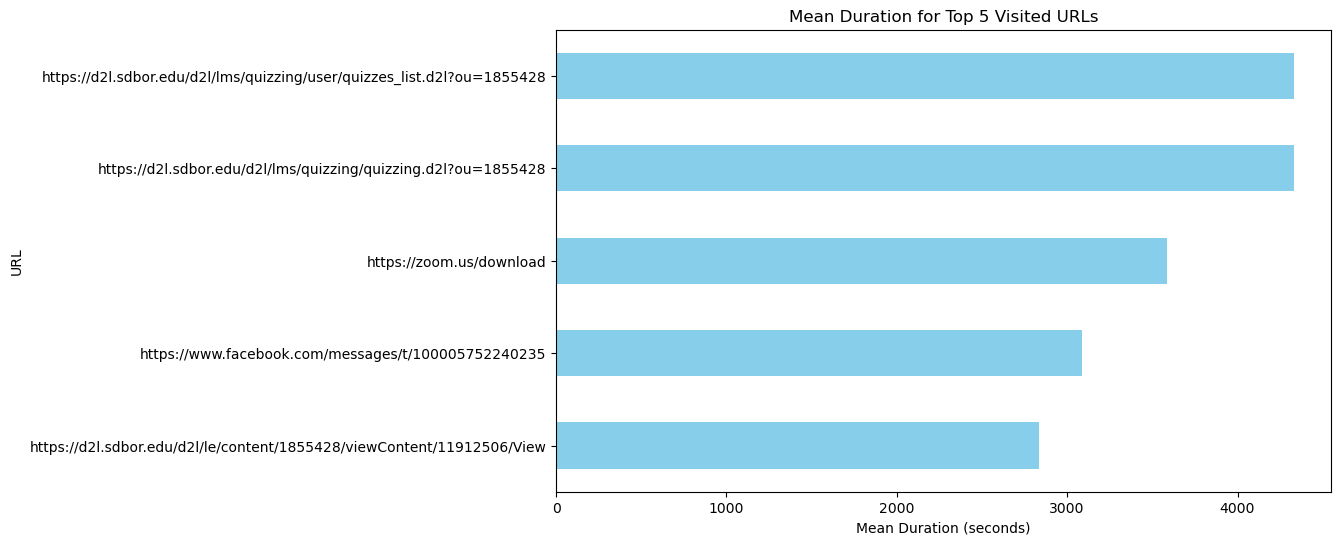

In [10]:
top_n_urls = 5 

top_urls = df['URL'].value_counts().nlargest(top_n_urls).index
mean_durations = df[df['URL'].isin(top_urls)].groupby('URL')['Duration'].mean()

plt.figure(figsize=(10, 6))
mean_durations.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Mean Duration (seconds)')
plt.ylabel('URL')
plt.title(f'Mean Duration for Top {top_n_urls} Visited URLs')
plt.show()

## Visualization 03: Count of Interested Categories

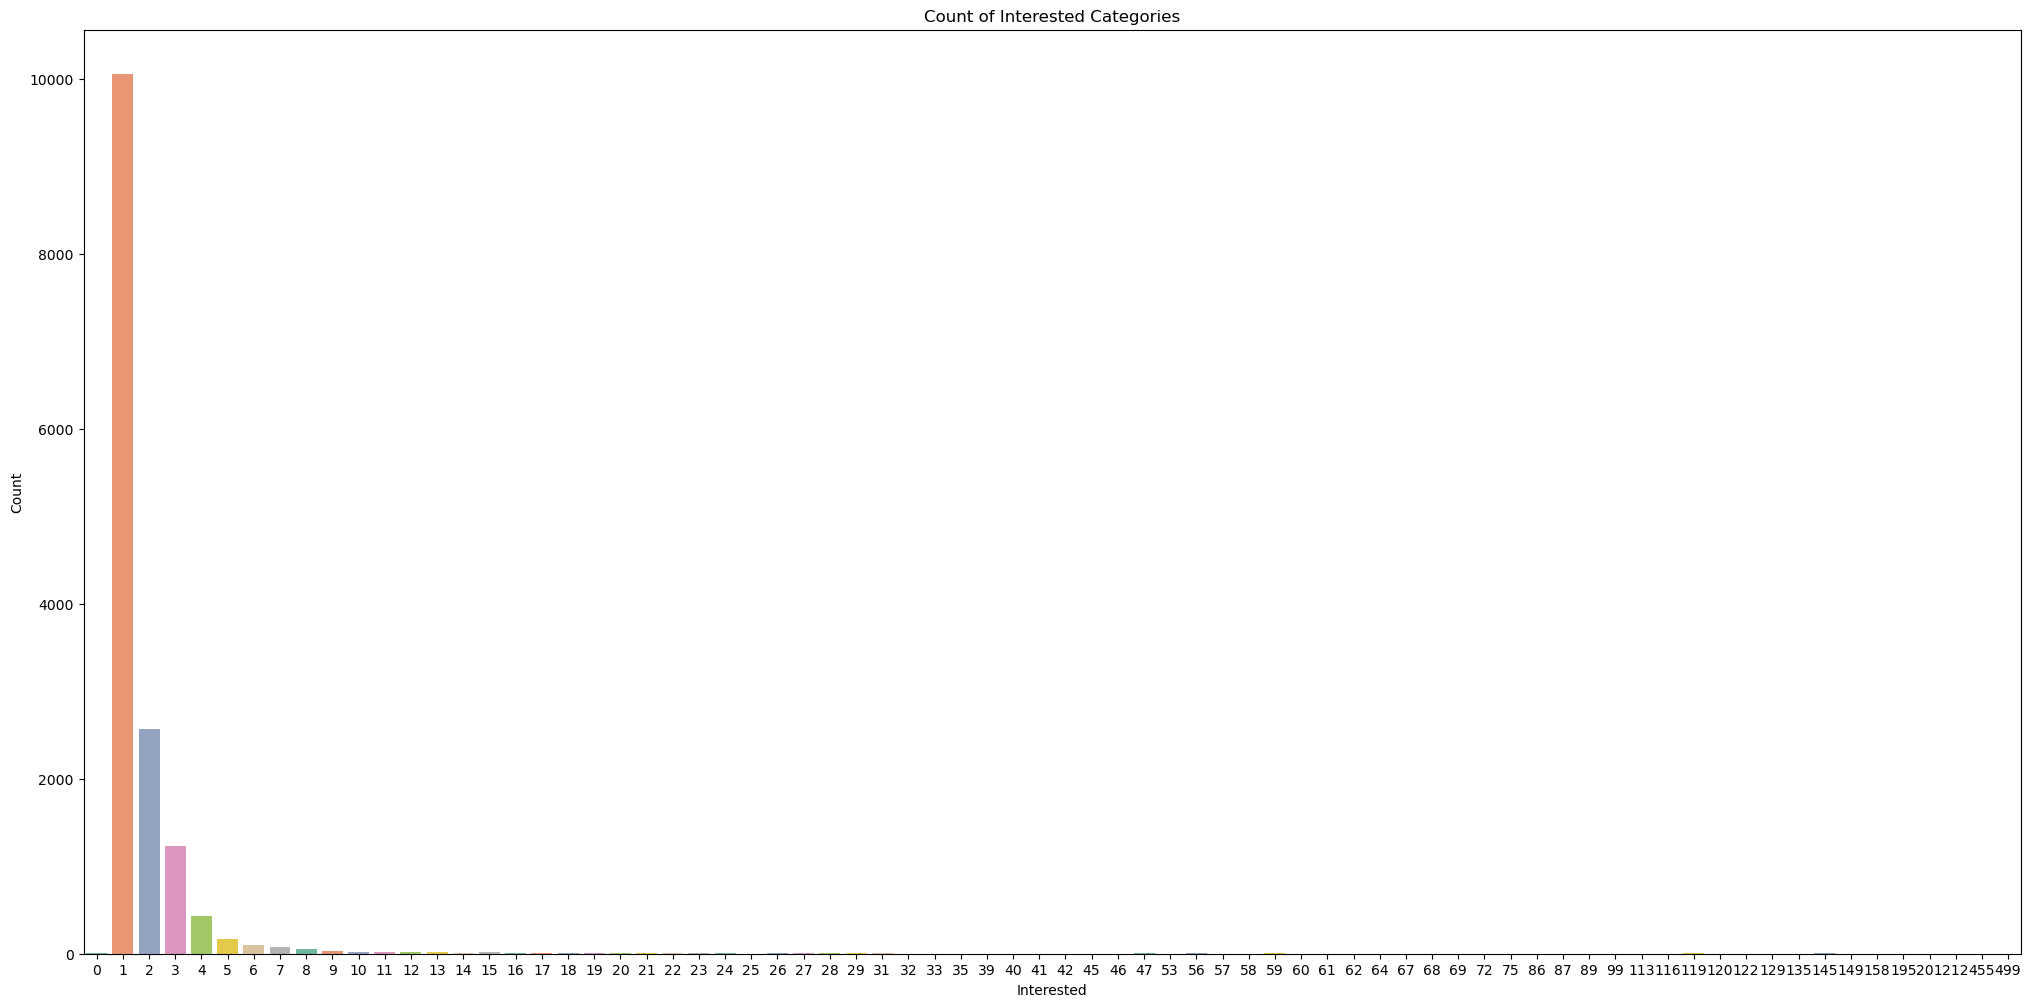

In [11]:
plt.figure(figsize=(25, 12))
sns.countplot(x='Interested', data=df, palette='Set2')
plt.xlabel('Interested')
plt.ylabel('Count')
plt.title('Count of Interested Categories')
plt.show()

## Visualization 04: Pair plot

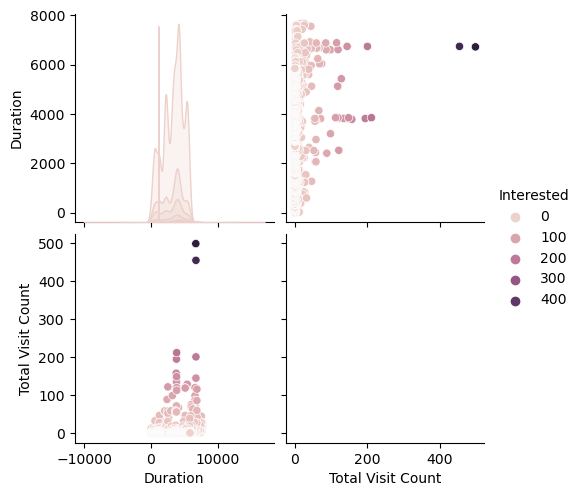

In [12]:
sns.pairplot(df, hue='Interested', vars=['Duration', 'Total Visit Count'])
plt.show()

## Visualization 05: Box plot for Duration and Interested

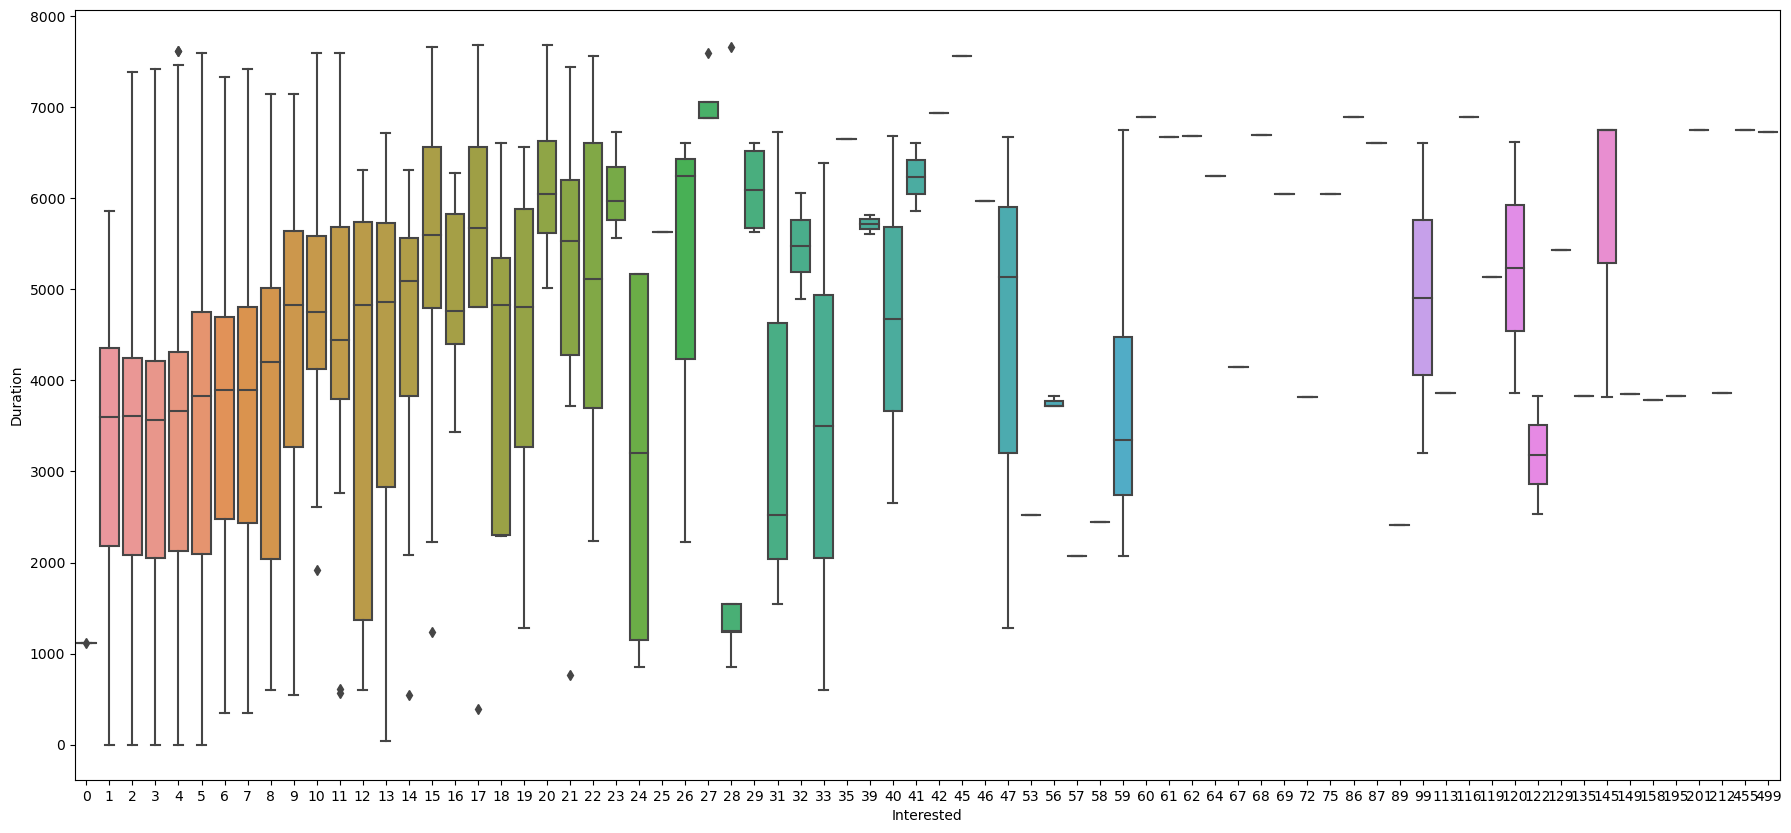

In [13]:
plt.figure(figsize=(22, 10))
sns.boxplot(x='Interested', y='Duration', data=df)
plt.xlabel('Interested')
plt.ylabel('Duration')
plt.show()

## Visualization 06: Word Cloud for Keywords

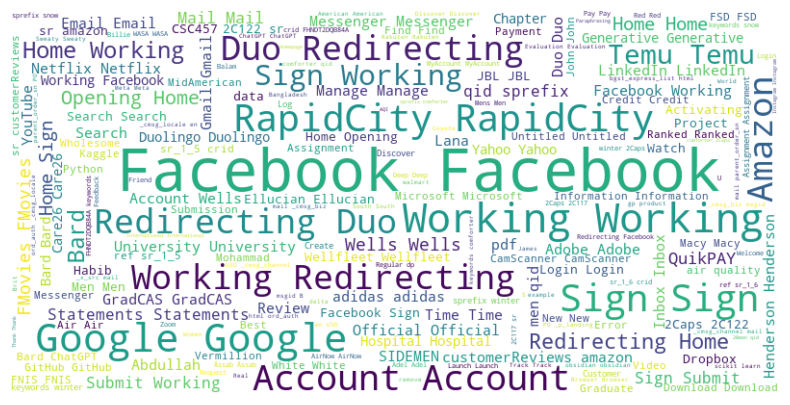

In [14]:
keywords_cloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Keyword'].dropna()))
plt.figure(figsize=(10, 5))
plt.imshow(keywords_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Visualization 07: Correlation Heatmap

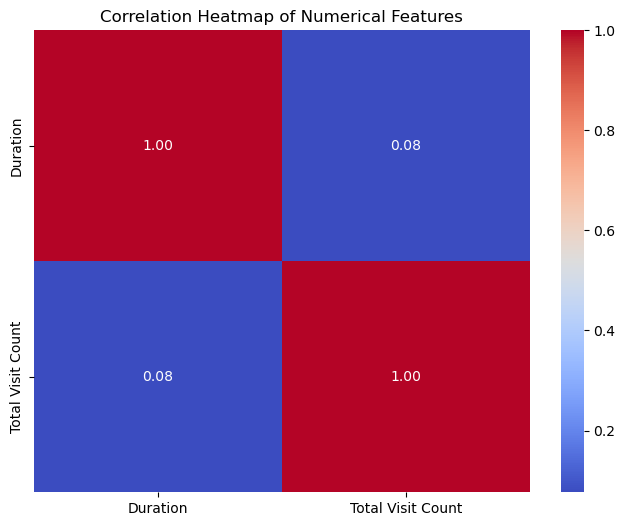

In [15]:
plt.figure(figsize=(8, 6))
correlation_matrix = df[['Duration', 'Total Visit Count']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## One-hot encode categorical features

In [16]:
df = pd.get_dummies(df, columns=['Domain', 'Keyword'])

## Define features & target variable

In [17]:
features = ['Duration', 'Total Visit Count'] + list(df.columns[df.columns.str.startswith('Domain_')]) + list(df.columns[df.columns.str.startswith('Keyword_')])
X = df[features]
y = df['Interested']

## Handle Class Imbalance using class weights

In [19]:
class_weights = {0: 1, 1: 10}

## Cross-Validation with StratifiedKFold

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Create a pipeline with StandardScaler & Logistic Regression

In [21]:
model = Pipeline([
    ('scaling', StandardScaler()),
    ('classification', LogisticRegression(random_state=42, max_iter=2000, solver='liblinear', C=1.0, class_weight=class_weights))
])

## Initiating parameter grid for grid search

In [22]:
# Define the parameter grid for grid search
param_grid = {
    'scaling__with_mean': [True, False],
    'classification__max_iter': [1000, 3000, 5000],
    'classification__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'classification__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 20}]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X, y)

/Users/abdullahalrakin/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('classification',
                                        LogisticRegression(class_weight={0: 1,
                                                                         1: 10},
                                                           max_iter=2000,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'classification__C': [0.001, 0.01, 0.1, 1.0, 10.0,
                                               100.0],
                         'classification__class_weight': [{0: 1, 1: 1},
                                                          {0: 1, 1: 5},
                                                          {0: 1, 1: 10},
                                                          {0: 1, 1: 20}],
                         'classification__max_iter': [1000, 3000, 5000],
                         'scaling__with_mean': [True, False]},
             scoring='accuracy')

## Print the best parameters and corresponding accuracy

In [23]:
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Best Parameters:  {'classification__C': 100.0, 'classification__class_weight': {0: 1, 1: 20}, 'classification__max_iter': 1000, 'scaling__with_mean': True}
Best Accuracy:  0.8266649046562797


## Display Cross-Validation Scores

In [24]:
print("Cross-Validation Scores: ", grid_search.cv_results_['mean_test_score'])

Cross-Validation Scores:  [0.69420865 0.69153648 0.69420865 0.69153648 0.69420865 0.69153648
 0.69334031 0.69093575 0.69334031 0.69093575 0.69334031 0.69093575
 0.69193764 0.68091642 0.69193764 0.68091642 0.69193764 0.68091642
 0.68165107 0.68051549 0.68165107 0.68051549 0.68165107 0.68051549
 0.71431384 0.70703283 0.71431384 0.70703283 0.71431384 0.70703283
 0.69607884 0.69447576 0.69607884 0.69447576 0.69607884 0.69447576
 0.69574474 0.68933203 0.69574474 0.68933203 0.69574474 0.68933203
 0.68438952 0.68338779 0.68438952 0.68338779 0.68438952 0.68338779
 0.7408988  0.73849417 0.7408988  0.73849417 0.7408988  0.73849417
 0.73568867 0.73488723 0.73568867 0.73488723 0.73568867 0.73488723
 0.73522114 0.73488707 0.73522114 0.73488707 0.73522114 0.73488707
 0.73461991 0.73421916 0.73461991 0.73421916 0.73461991 0.73421916
 0.76641423 0.7645438  0.76641423 0.7645438  0.76641423 0.7645438
 0.76367598 0.76133797 0.76367598 0.76133797 0.76367598 0.76133797
 0.76320844 0.76080359 0.76320844 0.7

## Make predictions using cross-validation with the best estimator

In [25]:
y_pred = grid_search.predict(X)

## Display Classification Report and Confusion Matrix

In [26]:
print("Classification Report:\n", classification_report(y, y_pred, zero_division=1))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00     10061
           2       0.75      0.92      0.83      2572
           3       0.77      0.65      0.71      1232
           4       0.72      0.46      0.56       430
           5       0.82      0.41      0.54       167
           6       0.71      0.35      0.46       104
           7       0.69      0.38      0.49        72
           8       0.68      0.42      0.52        50
           9       0.29      0.22      0.25        36
          10       0.67      0.22      0.33        18
          11       0.73      0.48      0.58        23
          12       0.67      0.18      0.29        22
          13       1.00      0.28      0.43        18
          14       1.00      0.33      0.50         9
          15       0.44      0.57      0.50        21
          16       0.82      1.00      0.90         9
   

## Visualization 08: Visualize the confusion matrix with "Predicted" & "Actual"

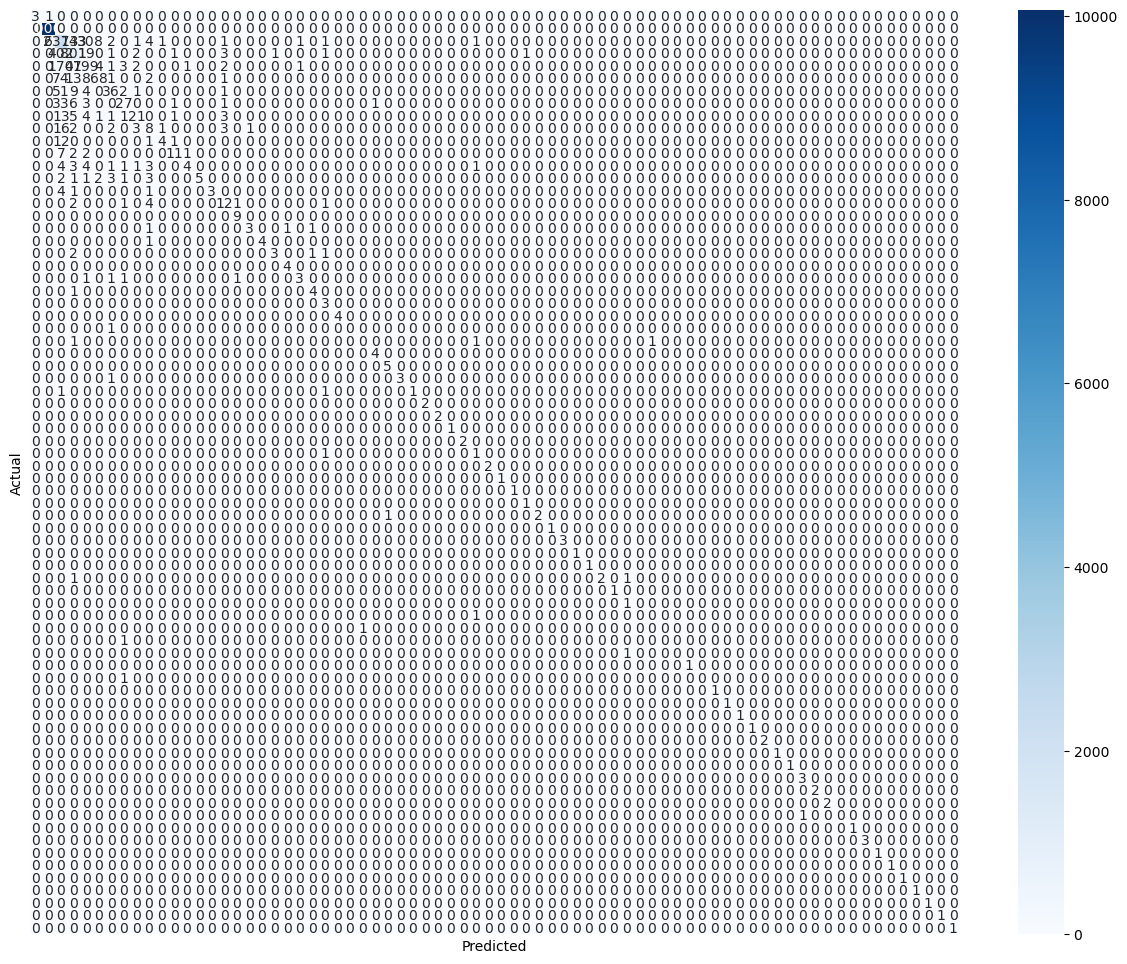

In [27]:
plt.figure(figsize=(15, 12))
conf_matrix = confusion_matrix(y, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=False, yticklabels=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Project Overview

This project involves the creation and analysis of a custom dataset we derived from our web browser history. The dataset is utilized to optimize web search using logistic regression. The following key steps and visualizations are implemented:

## Dataset Creation:

- Browser history data is extracted from the SQLite database.
- Relevant columns such as visit times, URL, title, and visit count are selected.

## Data Preprocessing:

- Time-related columns are formatted into datetime, and the duration is calculated.
- Unnecessary columns are dropped for streamlined analysis.

## Feature Engineering:

- Duration is converted to seconds.
- Additional information is extracted from URL and title.

## Target Variable Generation:

- A binary target variable 'Interested' is created based on visit count.

## Data Visualization:

- Top visited domains are visualized.
- Mean duration for top visited URLs is illustrated.
- Distribution of 'Interested' categories is displayed.
- Pair plot and box plot visualize relationships and distributions.
- Word cloud is generated for keywords.

## Correlation Analysis:

- Correlation heatmap is created for numerical features.

## One-Hot Encoding:

- Categorical features ('Domain' and 'Keyword') are one-hot encoded.

## Modeling with Logistic Regression:

- Logistic regression model is trained using stratified k-fold cross-validation.
- Class imbalance is addressed with appropriate class weights.

## Hyperparameter Tuning:

- Grid search is employed to find optimal hyperparameters.

## Performance Evaluation:

- Best parameters and accuracy are printed.
- Cross-validation scores are displayed.
- Classification report and confusion matrix are presented.

## Confusion Matrix Visualization:

- A detailed confusion matrix is visualized for model performance assessment.

*Note: Contributions are distributed equally between Abdullah Al Rakin and Mohammad Navid Nayyem.*
